In [12]:
import sys
sys.path.append("../")
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from utils.inkml2img import convert_dir
import warnings
import tqdm

warnings.filterwarnings('ignore')

In [13]:
device = torch.device('cpu')

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('gpu')

device

device(type='mps')

In [14]:
PATH_TO_DATA = '../data/'
PATH_TO_HANDWRITTEN = PATH_TO_DATA + 'handwritten/'
#train_handwritten_df = convert_dir(PATH_TO_HANDWRITTEN + 'train', PATH_TO_HANDWRITTEN + "train")
#train_handwritten_df.to_csv(PATH_TO_DATA + 'train_handwritten.csv', index=False)
#val_handwritten_df = convert_dir(PATH_TO_HANDWRITTEN + 'test', PATH_TO_HANDWRITTEN + "test")
#val_handwritten_df.to_csv(PATH_TO_DATA + 'val_handwritten.csv', index=False)

train_handwritten_df = pd.read_csv(PATH_TO_DATA + 'train_handwritten.csv')
val_handwritten_df = pd.read_csv(PATH_TO_DATA + 'val_handwritten.csv')
val_handwritten_df

,formula,image
0,$r_2 - r_1 = R$,../data/handwritten/test/126_em_481.png
1,$G_u = 2 M_{u v} M_v$,../data/handwritten/test/125_em_428.png
2,$p_A = u + c [L + \frac{1}{3}(a-b)]$,../data/handwritten/test/120_em_293.png
3,$M N = N M$,../data/handwritten/test/123_em_362.png
4,$\mu_n = E[X^n]$,../data/handwritten/test/105_em_71.png
...,...,...
666,$S^{4m+1}$,../data/handwritten/test/105_em_80.png
667,$ \phi ^ {3} + 3 \phi ^ {2} + 18 \phi + 5 + 12 $,../data/handwritten/test/rit_42190_2.png
668,"$a_2 = \frac{P[x_0, x_1] - P[x_1, x_2]}{x0 - x...",../data/handwritten/test/104_em_56.png
669,$\frac{P}{640}$,../data/handwritten/test/121_em_318.png


In [15]:

def fix_path(path):
    return PATH_TO_DATA + "images/" + path

train_df = pd.read_csv(PATH_TO_DATA + 'im2latex_train.csv')
val_df = pd.read_csv(PATH_TO_DATA + 'im2latex_validate.csv')
test_df = pd.read_csv(PATH_TO_DATA + 'im2latex_test.csv')


dataframes = [train_df, val_df, test_df]

for df in dataframes:
    df['image'] = df['image'].map(lambda x: fix_path(x))

print(f'train len before {len(train_df)}')

train_df = pd.concat([train_df, train_handwritten_df])
val_df = pd.concat([val_df, val_handwritten_df])

print(f'train length after {len(train_df)}')

train_df

train len before 75275
train length after 84111


,formula,image
0,\widetilde \gamma _ { \mathrm { h o p f } } \s...,../data/images/66667cee5b.png
1,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \...",../data/images/1cbb05a562.png
2,S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...,../data/images/ed164cc822.png
3,\hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a ...,../data/images/e265f9dc6b.png
4,"\, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } ...",../data/images/242a58bc3a.png
...,...,...
8831,\frac { x_1 } { \frac { x_2 } { \frac { x_3 }...,../data/handwritten/train/200923-1556-78.png
8832,$y = \frac{x\prime\sin\theta+y\prime\sin(w\pri...,../data/handwritten/train/92_edwin.png
8833,$(103 / (18 + 134)) + 109 \leq 110$,../data/handwritten/train/formulaire014-equati...
8834,\sin^{2} \theta + \cos^{2} \theta = 1,../data/handwritten/train/TrainData1_0_sub_9.png


In [17]:
a = train_df['formula'].iloc[0]


'\\widetilde \\gamma _ { \\mathrm { h o p f } } \\simeq \\sum _ { n > 0 } \\widetilde { G } _ { n } { \\frac { ( - a ) ^ { n } } { 2 ^ { 2 n - 1 } } }'

In [6]:
train_equations = train_df['formula']
train_equations.to_csv('../data/train_equations.txt', index=False, header=False)

In [ ]:
def generate_tokenizer(equations, output, vocab_size):
    from tokenizers import Tokenizer, pre_tokenizers
    from tokenizers.models import BPE
    from tokenizers.trainers import BpeTrainer
    tokenizer = Tokenizer(BPE())
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
    trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], vocab_size=vocab_size, show_progress=True)
    tokenizer.train(equations, trainer)
    tokenizer.save(path=output, pretty=False)

generate_tokenizer('../data/tokenizer.json', 8000)



In [4]:
class ImagesDataset(Dataset):
    def __init__(self, image_paths, formulas, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.formulas = formulas

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        formula = self.formulas[index]

        if self.transform:
            image = self.transform(image)

        return image, formula


transform = transforms.Compose([
    transforms.Resize((224, 600)),  # Resize to a specific size
    transforms.ToTensor(),           # Convert to tensor
])

In [5]:
# HYPERPARAMETERS
# -------------------------------------------------
BATCH_SIZE = 32
# -------------------------------------------------

train_dataset = ImagesDataset(train_df['image'], train_df['formula'], transform=transform)
val_dataset = ImagesDataset(val_df['image'], val_df['formula'], transform=transform)
test_dataset = ImagesDataset(test_df['image'], test_df['formula'], transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

'C = [ n _ { 0 } ] = \\frac { 1 } { \\operatorname { s i n } ( \\frac { 2 \\pi } { s + 1 } ) }'

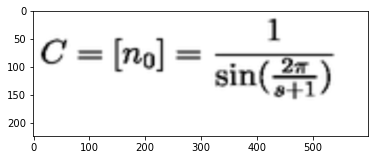

In [6]:
im, label = next(iter(train_dataloader))

plt.imshow(im[0][0], cmap='gray')
label[0]